In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 1. 데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/workspace/Exploration/Ex02/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

In [3]:
print('train shape is :', train.shape)
display(train.info())
print('test shape is :', test.shape)
display(test.info())

train shape is : (15035, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 

None

test shape is : (6468, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-n

None

In [4]:
# 컬럼을 확인했으니, taget에 해당하는 데이터를 분리해 줌
label = train['price']

In [5]:
display(train.head())
display(test.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [6]:
display(train.describe())
display(test.describe())

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,6468.000000,6468.00000,6468.000000,6468.000000,6.468000e+03,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000
mean,18268.500000,3.37786,2.118313,2075.981293,1.469916e+04,1.488327,0.008658,0.235467,3.416821,7.655535,1779.556277,296.425015,1970.949443,86.933983,98077.587044,47.558726,-122.214039,1974.429654,12659.800402
std,1867.295103,0.99064,0.775851,910.613001,3.870428e+04,0.544007,0.092652,0.773616,0.658267,1.161900,820.834051,447.218709,29.292377,407.210870,53.936590,0.139659,0.139766,671.597761,26380.422371
min,15035.000000,0.00000,0.000000,370.000000,6.810000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.512000,460.000000,748.000000
25%,16651.750000,3.00000,1.750000,1420.000000,5.084000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98032.000000,47.467175,-122.327000,1480.000000,5100.000000
50%,18268.500000,3.00000,2.250000,1920.000000,7.607000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1550.000000,0.000000,1975.000000,0.000000,98065.000000,47.572150,-122.229000,1820.000000,7664.500000
75%,19885.250000,4.00000,2.500000,2520.000000,1.066425e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2190.000000,590.000000,1997.000000,0.000000,98118.000000,47.677400,-122.123000,2370.000000,10125.000000
max,21502.000000,33.00000,6.750000,9640.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8020.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.364000,5610.000000,438213.000000


In [7]:
print('count of null in train data\n',train.isnull().sum())
print('count of null in test data\n',test.isnull().sum())
print('count of null in label data\n',label.isnull().sum())

count of null in train data
 id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
count of null in test data
 id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
count of null in label data
 0


In [8]:
# 데이터 처리전 데이터 세이브

train_save = train
test_save = test
label_save = label

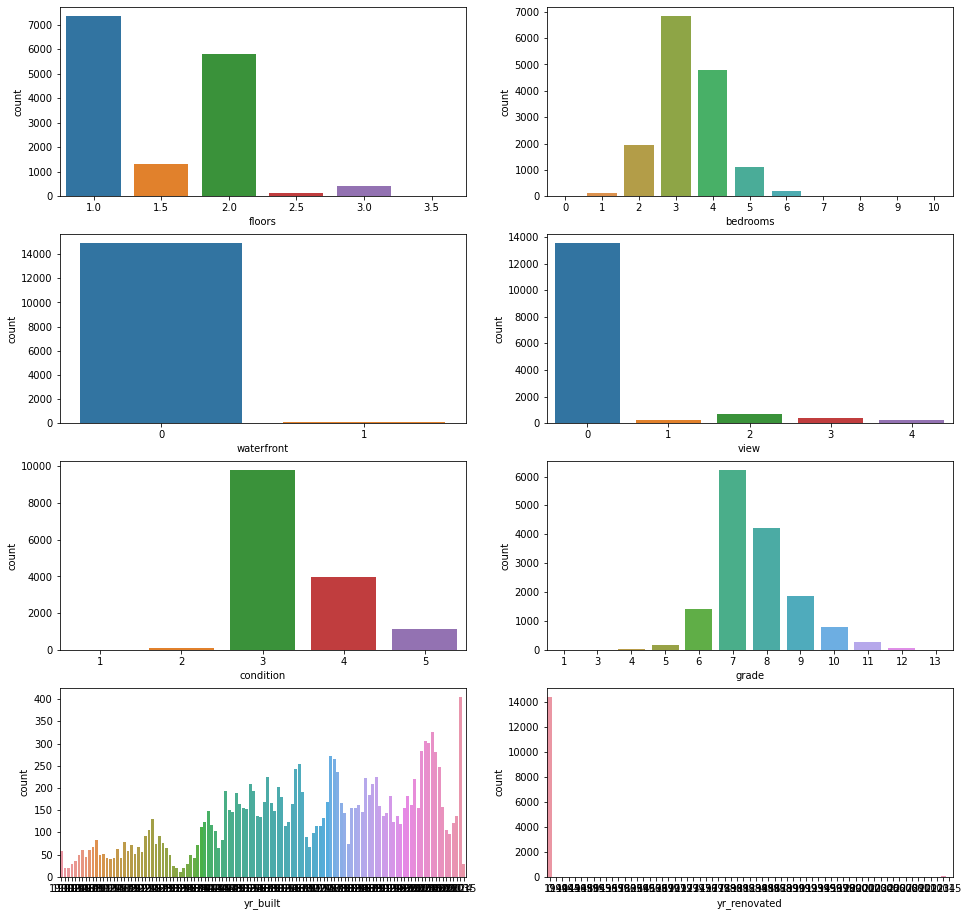

In [9]:
# 결측값이 없는 것으로 확인하였음
# 몇가지 칼럼이 카테고리형 인 것으로 확인되어 해당 칼럼에 대한 시각화 수행

fig, ax1 = plt.subplots(figsize=(16, 16), ncols=2, nrows=4)
category_feat_list = ['floors', 'bedrooms', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']
for i, category_feat in enumerate(category_feat_list):
    row = int(i/2)
    col = i%2
    sns.countplot(x=category_feat, data=train, ax=ax1[row][col])

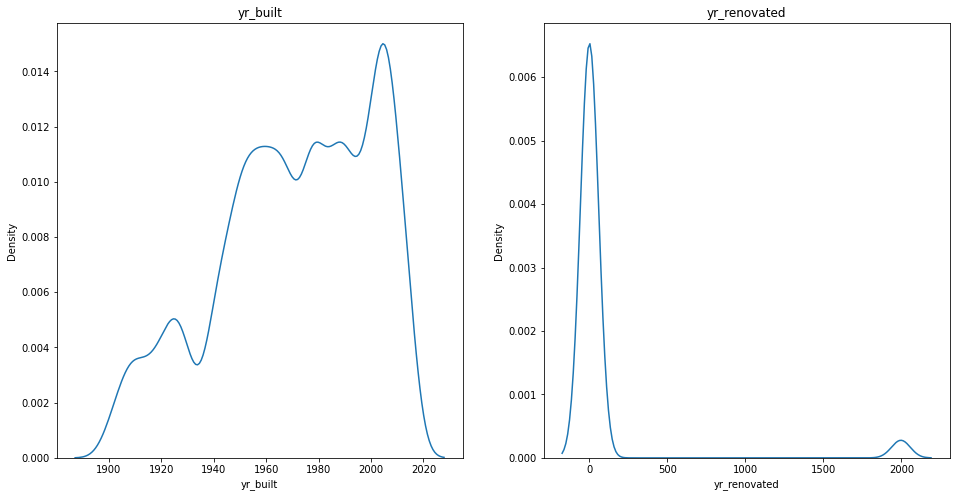

In [10]:
# 일부 데이터의 경우 countplot으로 면밀히 보이지 않음으로 다른 방식으로 시각화

fig, ax2 = plt.subplots(figsize=(16, 8), ncols=2, nrows=1)
category_feat_list2 = ['yr_built', 'yr_renovated']
for i, category_feat in enumerate(category_feat_list2):
    col = i%2
    ax2[col].set_title(category_feat)
    sns.kdeplot(x=category_feat, data=train, ax=ax2[col])

In [11]:
# yr_built 및 yr_renovated에 대하여 구간화가 필요한 것으로 확인됨
# yr_built의 경우 1950년울 전후로, 2000년을 전후로 변동이 보임으로 이를 기준으로 구간화를 진행함
# yt_renovated의 경우 renovated 여부에 따라 뤈 핫 인코딩이 필요함

def yr_sectionazation(dataframe):
    # yr_built 구간화
    bins = [1900, 1950, 2000, 2020]
    labels = ['1950s', '2000s', '2020s']
    yr_b = pd.cut(dataframe['yr_built'], bins = bins, labels=labels)
    yr_b = pd.DataFrame(yr_b)
    yr_b = pd.get_dummies(yr_b)
    # yr_renovated의 경우 분포에 따라 구간화를 진행하겠음
    bins2 = [1900, 2000, 2020]
    labels2 = ['old', 'recent']
    yr_r = pd.cut(dataframe['yr_renovated'], bins = bins2, labels=labels2)
    yr_r = pd.DataFrame(yr_r)
    yr_r = pd.get_dummies(yr_r)
    for i in labels:
        dataframe['yr_built_'+i] = yr_b['yr_built_'+i]
    for i in labels2:
        dataframe['yr_renovated_'+i] = yr_r['yr_renovated_'+i]
    return

yr_sectionazation(train)

train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,yr_built_1950s,yr_built_2000s,yr_built_2020s,yr_renovated_old,yr_renovated_recent
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,98178,47.5112,-122.257,1340,5650,0,1,0,0,0
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,98028,47.7379,-122.233,2720,8062,1,0,0,0,0
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,98074,47.6168,-122.045,1800,7503,0,1,0,0,0
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,98003,47.3097,-122.327,2238,6819,0,1,0,0,0
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,98198,47.4095,-122.315,1650,9711,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,98056,47.5137,-122.167,2520,6023,0,0,1,0,0
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,98136,47.5537,-122.398,2050,6200,0,0,1,0,0
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,98103,47.6993,-122.346,1530,1509,0,0,1,0,0
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,98146,47.5107,-122.362,1830,7200,0,0,1,0,0


In [12]:
# datetime을 연, 월, 일로 분류
def trans_datetime(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe['year'] = dataframe['date'].dt.year
    dataframe['month'] = dataframe['date'].dt.month
    dataframe['day'] = dataframe['date'].dt.day
    return

trans_datetime(train)

train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,yr_built_1950s,yr_built_2000s,yr_built_2020s,yr_renovated_old,yr_renovated_recent,year,month,day
0,0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1340,5650,0,1,0,0,0,2014,10,13
1,1,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,2720,8062,1,0,0,0,0,2015,2,25
2,2,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1800,7503,0,1,0,0,0,2015,2,18
3,3,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,...,2238,6819,0,1,0,0,0,2014,6,27
4,4,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0,0,...,1650,9711,0,1,0,0,0,2015,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,2014-10-14,610685.0,4,2.50,2520,6023,2.0,0,0,...,2520,6023,0,0,1,0,0,2014,10,14
15031,15031,2015-03-26,1007500.0,4,3.50,3510,7200,2.0,0,0,...,2050,6200,0,0,1,0,0,2015,3,26
15032,15032,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,1530,1509,0,0,1,0,0,2014,5,21
15033,15033,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,1830,7200,0,0,1,0,0,2015,2,23


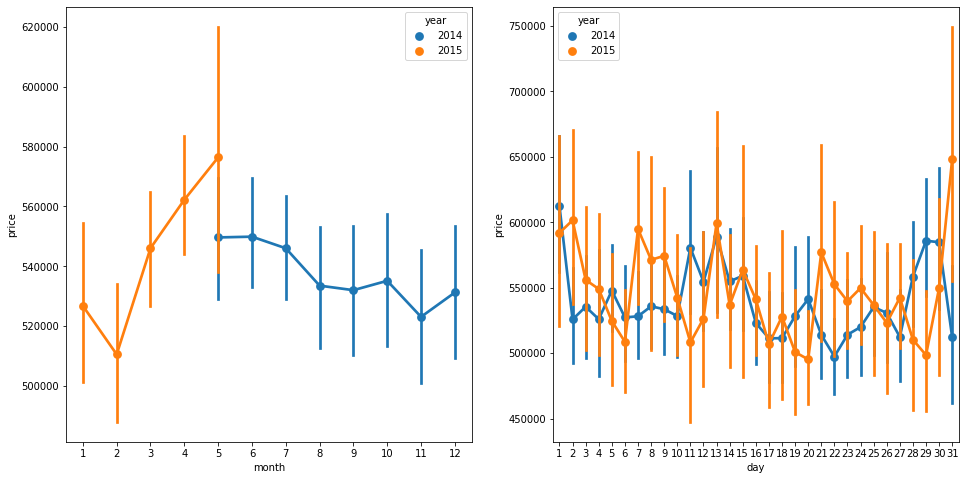

In [13]:
# 연속형(시간) 변수들에 대하여 시각화
fig, ax3 = plt.subplots(figsize=(16, 8), ncols=2, nrows=1)
time_feat_list = ['month', 'day']
for i, time_feat in enumerate(time_feat_list):
    col = i%3
    sns.pointplot(x=time_feat, y='price', hue ='year', data=train, ax=ax3[col])
# 구매 년도보다 구매 월이 중요한 차이를 보이는 것으로 확인됨
# 구매일은 큰 경향이 없는 것으로 확인됨

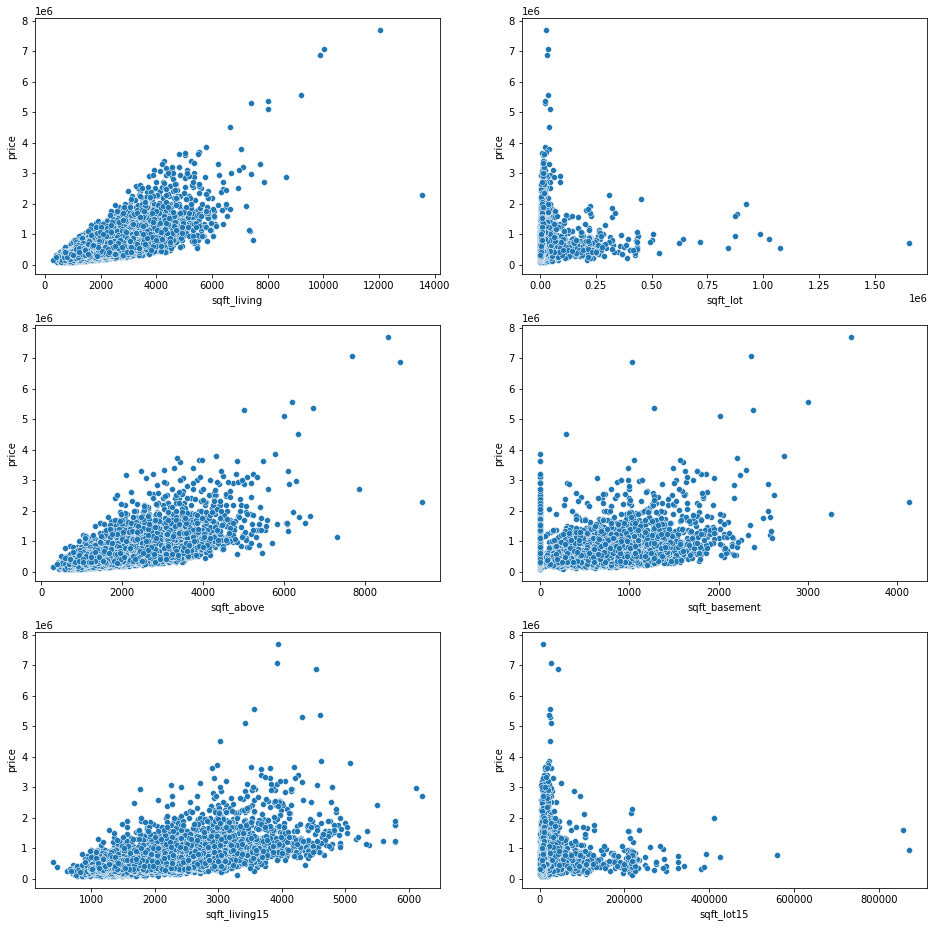

In [14]:
# 연속형(면적기반) 변수들에 대하여 시각화
fig, ax4 = plt.subplots(figsize=(16, 16), ncols=2, nrows=3)
serial_feat_list = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
for i, serial_feat in enumerate(serial_feat_list):
    row = int(i/2)
    col = i%2
    sns.scatterplot(x=serial_feat, y='price', data=train, ax=ax4[row][col])
# 모두 상관성이 있는 것으로 확인됨

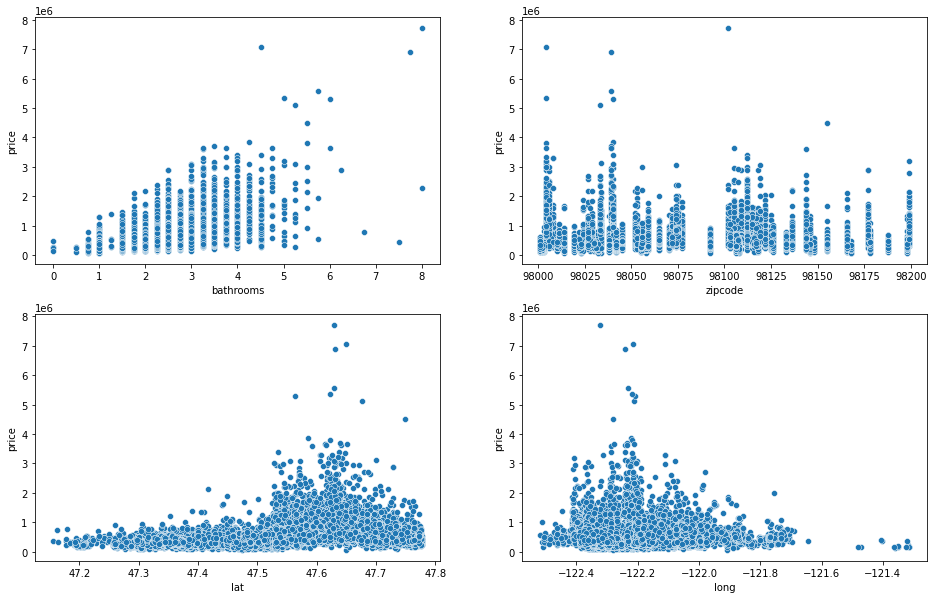

In [15]:
# 그 외 변수들에 대하여 시각화
fig, ax5 = plt.subplots(figsize=(16, 10), ncols=2, nrows=2)
serial_feat_list2 = ['bathrooms', 'zipcode', 'lat', 'long']
for i, serial_feat in enumerate(serial_feat_list2):
    row = int(i/2)
    col = i%2
    sns.scatterplot(x=serial_feat, y='price', data=train, ax=ax5[row][col])
# 위도와 경도가 예상보다 상관성이 있는 것 같음
# 부유한 지역과 아닌 지역이 나뉘는 것으로 추정
# 우편번호는 예상대로 큰 의미가 없는 것으로 추정

<function matplotlib.pyplot.show(close=None, block=None)>

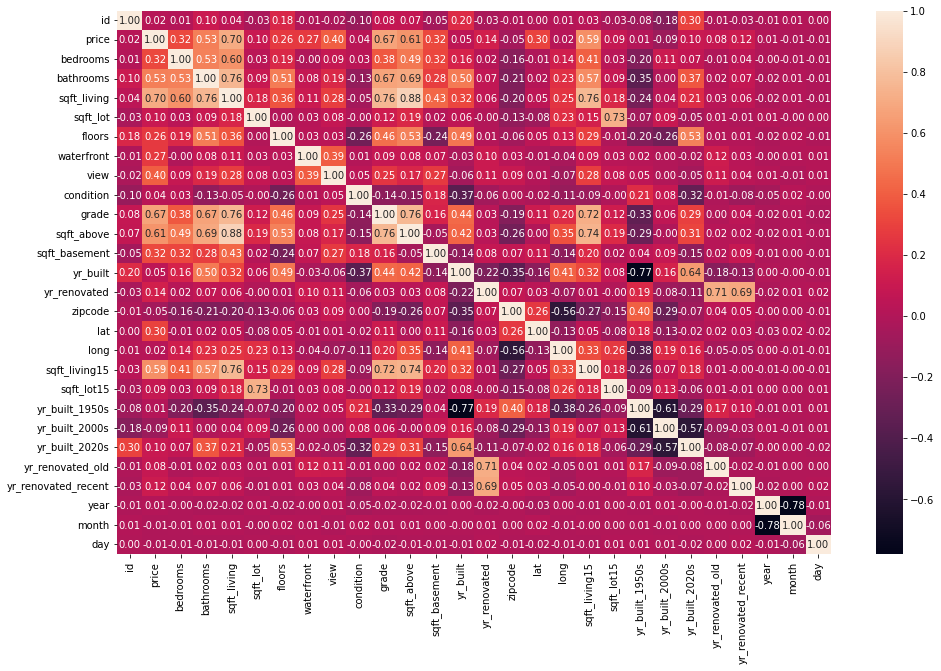

In [16]:
corr = train.corr()
plt.figure(figsize=(16,10))

sns.heatmap(corr, annot=True, fmt='.2f')
plt.show

In [17]:
# 위 시각화를 토대로 의미 없는 데이터에 대한 drop 조치를 진행하고, 원 핫 인코딩도 진행
encording_feat = ['floors', 'bedrooms', 'waterfront', 'view', 'condition', 'grade', 'month', 'day']
drop_feat = ['id', 'price', 'date', 'yr_built', 'yr_renovated', 'zipcode', 'year']

train = pd.get_dummies(train, columns = ['floors', 'waterfront', 'month', 'day'])

for i in drop_feat:
    train.drop(columns=i,axis=1,inplace=True)

train

,bedrooms,bathrooms,sqft_living,sqft_lot,view,condition,grade,sqft_above,sqft_basement,lat,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,3,1.00,1180,5650,0,3,7,1180,0,47.5112,...,0,0,0,0,0,0,0,0,0,0
1,2,1.00,770,10000,0,3,6,770,0,47.7379,...,0,0,0,1,0,0,0,0,0,0
2,3,2.00,1680,8080,0,3,8,1680,0,47.6168,...,0,0,0,0,0,0,0,0,0,0
3,3,2.25,1715,6819,0,3,7,1715,0,47.3097,...,0,0,0,0,0,1,0,0,0,0
4,3,1.50,1060,9711,0,3,7,1060,0,47.4095,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,4,2.50,2520,6023,0,3,9,2520,0,47.5137,...,0,0,0,0,0,0,0,0,0,0
15031,4,3.50,3510,7200,0,3,9,2600,910,47.5537,...,0,0,0,0,1,0,0,0,0,0
15032,3,2.50,1530,1131,0,3,8,1530,0,47.6993,...,0,0,0,0,0,0,0,0,0,0
15033,4,2.50,2310,5813,0,3,8,2310,0,47.5107,...,0,1,0,0,0,0,0,0,0,0


<AxesSubplot:>

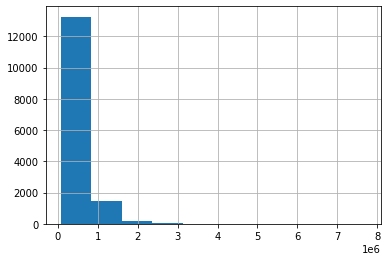

In [18]:
# 라벨 데이터에 대하여 정규화 시행
label.hist()

<AxesSubplot:>

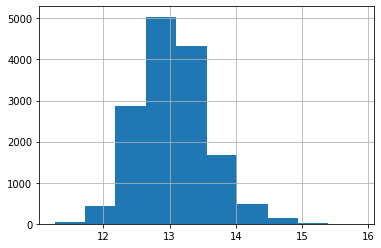

In [19]:
label=np.log1p(label)
label.hist()

In [20]:
# 모델 선정 함수 생성
# 모델 수행 및 평가 함수 생성
# grid_cv 하이퍼 파라미터 개선 함수 생성
# 제출형식에 맞게 계측 결과를 저장하는 함수 생성

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

gboost = GradientBoostingRegressor(random_state=0)
xgboost = xgb.XGBRegressor(random_state=0)
lightgbm = lgb.LGBMRegressor(random_state=0)

models = [gboost, xgboost, lightgbm]

def rmse_cal(label, pred):
    rmse = np.sqrt(mean_squared_error(np.expm1(label), np.expm1(pred)))
    return rmse

def get_cv_score(model, train, label):
    kfold = KFold(n_splits=5).get_n_splits(train)
    CV_score = np.mean(cross_val_score(model, X=train, y=label, cv=kfold))
    print(model.__class__.__name__)
    print(CV_score)
    return

def reg_predict_rmse(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    rmse = rmse_cal(y_test, y_pred)
    print(model.__class__.__name__)
    print('RMSE is', rmse)
    
def reg_coef_plot(model, x, i=20):
    feat_s = pd.Series(model.feature_importances_, index=x.columns)
    feat_s = feat_s.sort_values(ascending=False)[:i]
    sns.barplot(x=feat_s.values , y=feat_s.index)
    
def my_GridSearch(model, x_train, y_train, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(x_train, y_train)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [21]:
#test 데이터에 대하여 train 데이터에 시행한 과정을 동일히 수행함

trans_datetime(test)
yr_sectionazation(test)

drop_feat = ['id', 'date', 'yr_built', 'yr_renovated', 'zipcode', 'year']

test = pd.get_dummies(test, columns = ['floors', 'waterfront', 'month', 'day'])

for i in drop_feat:
    test.drop(columns=i,axis=1,inplace=True)

test

,bedrooms,bathrooms,sqft_living,sqft_lot,view,condition,grade,sqft_above,sqft_basement,lat,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,3,2.25,2570,7242,0,3,7,2170,400,47.7210,...,0,0,0,0,0,0,0,0,0,0
1,4,3.00,1960,5000,0,5,7,1050,910,47.5208,...,0,0,0,0,0,0,0,0,0,0
2,4,4.50,5420,101930,0,3,11,3890,1530,47.6561,...,0,0,0,0,0,0,0,0,0,0
3,3,1.00,1780,7470,0,3,7,1050,730,47.5123,...,0,0,0,0,0,0,0,0,0,0
4,3,2.50,1890,6560,0,3,7,1890,0,47.3684,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,3,1.75,1500,11968,0,3,6,1500,0,47.3095,...,0,0,0,0,1,0,0,0,0,0
6464,3,2.00,1490,1126,0,3,8,1490,0,47.5699,...,0,0,0,0,1,0,0,0,0,0
6465,3,2.50,1310,1294,0,3,8,1180,130,47.5773,...,0,0,0,0,0,0,0,0,0,0
6466,2,0.75,1020,1350,0,3,7,1020,0,47.5944,...,0,1,0,0,0,0,0,0,0,0


In [42]:
# gris_cv 및 cross_val을 이용하여 모델을 평가하였음
# 추가적으로 실제 분리된 테스트 및 검증 데이터로 모델의 rmse를 산출하여, 대회 기준에서의 모델 성능도 확인해 봄
# 시험 결과 양측 결과모두 LGBMRegressor가 가장 좋은 모델로 확인됨
for model1 in models:
    get_cv_score(model1, train, label)

X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=0)

for i, model2 in enumerate(models):
    reg_predict_rmse(model2, X_train, X_test, y_train, y_test)

GradientBoostingRegressor
0.8749985239138491
XGBRegressor
0.8928419246314447
LGBMRegressor
0.8995555434033454
GradientBoostingRegressor
RMSE is 169248.3268924011
XGBRegressor
RMSE is 145122.48291842183
LGBMRegressor
RMSE is 142138.7180273337


In [44]:
# 너무 많은 변수를 할당하니 27000회를 학습하며, 끝나지 않는 학습이 진행됬다
# 대략적으로 확인해 본 결과 n_estimator, max_depth, learning_rate 등이 중요한 하이퍼 파라미터인것 같다
# 위에서 이야기된 파라미터를 위주로 그리드 서치를 해야함
param_grid = {
    'n_estimators': [50, 100, 1000],
    'max_depth': [-1, 1, 5, 10],
    'num_leaves' : [70, 80],
    'learning_rate': [0.01, 0.1, 1],
    'subsample' : [0.6 , 0.8 , 1],
    'metric' : ['rmse', 'auc']
}

model = lightgbm

my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=50, num_leaves=80, subsample=0.6; total time=   1.3s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=50, num_leaves=80, subsample=0.8; total time=   1.1s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=50, num_leaves=80, subsample=1; total time=   1.1s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=70, subsample=0.6; total time=   2.8s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=70, subsample=0.8; total time=   2.1s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=70, subsample=1; total time=   2.9s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=80, subsample=0.6; total time=   2.2s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=80, subsample=0.8; to

[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=70, subsample=0.8; total time=   2.6s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=70, subsample=1; total time=   1.9s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=80, subsample=0.6; total time=   2.8s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=80, subsample=0.8; total time=   1.9s
[CV] END learning_rate=1, max_depth=10, metric=rmse, n_estimators=100, num_leaves=80, subsample=1; total time=   2.4s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=0.6; total time=   1.5s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=0.8; total time=   1.6s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   1.6s
[CV] END learning_rate=1, max_depth=10, metric=auc, 

[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   1.1s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=50, num_leaves=80, subsample=0.6; total time=   1.5s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=50, num_leaves=80, subsample=0.8; total time=   1.7s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=50, num_leaves=80, subsample=1; total time=   1.5s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=100, num_leaves=70, subsample=0.6; total time=   2.4s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=100, num_leaves=70, subsample=0.8; total time=   2.8s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=100, num_leaves=70, subsample=1; total time=   2.5s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=100, num_leaves=80, subsample=0.6; total time=   2.6s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_esti

[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=100, num_leaves=70, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=100, num_leaves=70, subsample=1; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=100, num_leaves=80, subsample=0.6; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=100, num_leaves=80, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=100, num_leaves=80, subsample=1; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.6; total time=   3.8s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.8; total time=   3.6s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=1; total time=   4.5s
[CV] END learning_rate=0.01

[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.8; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=1; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.6; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.6; total time=   3.7s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.8; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=1; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=1, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=1, metric=auc, n_estimators=50, num_leaves=80, subsample=0.6; total time=   0.6s
[CV] END learning_rate=0.01,

[CV] END learning_rate=0.01, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.6; total time=  11.5s
[CV] END learning_rate=0.01, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.8; total time=  11.9s
[CV] END learning_rate=0.01, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=1; total time=  10.9s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.6; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.6; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=50, num_leaves=70, subsample=1; total time=   1.6s
[CV] END learning_rate=0.01,

[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.6; total time=  25.7s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.8; total time=  27.9s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=70, subsample=1; total time=  21.2s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.6; total time=  29.1s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.8; total time=  28.7s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=80, subsample=1; total time=  26.4s
[CV] END learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=0.6; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=0.8; total time=   2.0s
[CV] END learning_

[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.6; total time=  27.6s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.8; total time=  24.2s
[CV] END learning_rate=0.01, max_depth=10, metric=rmse, n_estimators=1000, num_leaves=80, subsample=1; total time=  30.3s
[CV] END learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=80, subsample=0.6; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=80, subsample=0.8; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=80, subsample=1; total time=   1.8s
[CV] END learning_rate=0.01, ma

[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=70, subsample=1; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=70, subsample=1; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=70, subsample=1; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=80, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=80, subsample=0.6; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=80, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=50, num_leaves=80, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=1, metri

[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.6; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.8; total time=   3.0s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=1; total time=   3.9s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.6; total time=   3.7s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.8; total time=   2.8s
[CV] END learning_rate=0.1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=1; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=1, metric=auc, n_estimators=50, num_leaves=70, subsample=0.6; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=1, metric=auc, n_estimators=50, num_leaves=70, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.1, max_de

[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=100, num_leaves=80, subsample=1; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.6; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.8; total time=   8.5s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=70, subsample=1; total time=   9.2s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.6; total time=  10.3s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.8; total time=   9.2s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=1; total time=   8.8s
[CV] END learning_rate=0.1, max_depth=10, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.6; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=1

[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=100, num_leaves=80, subsample=1; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.6; total time=  11.3s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.8; total time=   9.3s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=70, subsample=1; total time=   9.5s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.6; total time=   9.6s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.8; total time=  10.5s
[CV] END learning_rate=0.1, max_depth=5, metric=auc, n_estimators=1000, num_leaves=80, subsample=1; total time=   8.7s
[CV] END learning_rate=0.1, max_depth=10, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=1

[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=70, subsample=0.8; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=70, subsample=1; total time=   2.4s
[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=80, subsample=0.6; total time=   2.7s
[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=80, subsample=0.8; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=80, subsample=1; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.6; total time=  20.8s
[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.8; total time=  19.5s
[CV] END learning_rate=0.1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=70, subsample=1; total time=  17.5s
[CV] END learning_rate=0.1, max_dep

[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=50, num_leaves=70, subsample=0.8; total time=   1.6s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   1.3s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   1.1s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=50, num_leaves=80, subsample=0.6; total time=   1.5s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=50, num_leaves=80, subsample=0.8; total time=   1.9s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=50, num_leaves=80, subsample=1; total time=   1.4s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=50, num_leaves=80, subsample=1; total time=   1.3s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimators=100, num_leaves=70, subsample=0.6; total time=   2.1s
[CV] END learning_rate=1, max_depth=-1, metric=auc, n_estimator

[CV] END learning_rate=1, max_depth=1, metric=rmse, n_estimators=100, num_leaves=80, subsample=1; total time=   0.8s
[CV] END learning_rate=1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.6; total time=   3.5s
[CV] END learning_rate=1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=0.8; total time=   3.0s
[CV] END learning_rate=1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=70, subsample=1; total time=   2.8s
[CV] END learning_rate=1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.6; total time=   3.5s
[CV] END learning_rate=1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.8; total time=   3.0s
[CV] END learning_rate=1, max_depth=1, metric=rmse, n_estimators=1000, num_leaves=80, subsample=1; total time=   3.7s
[CV] END learning_rate=1, max_depth=1, metric=auc, n_estimators=50, num_leaves=70, subsample=0.6; total time=   0.4s
[CV] END learning_rate=1, max_depth=1, metric=auc,

,learning_rate,max_depth,metric,n_estimators,num_leaves,subsample,score,RMSLE
140,0.01,10,auc,1000,70,1.0,-0.027344,0.165359
121,0.01,10,rmse,1000,70,0.8,-0.027344,0.165359
122,0.01,10,rmse,1000,70,1.0,-0.027344,0.165359
120,0.01,10,rmse,1000,70,0.6,-0.027344,0.165359
138,0.01,10,auc,1000,70,0.6,-0.027344,0.165359
...,...,...,...,...,...,...,...,...
56,0.01,1,auc,50,70,1.0,-0.205786,0.453636
57,0.01,1,auc,50,80,0.6,-0.205786,0.453636
58,0.01,1,auc,50,80,0.8,-0.205786,0.453636
41,0.01,1,rmse,50,80,1.0,-0.205786,0.453636


In [45]:
model = lgb.LGBMRegressor(learning_rate=0.01, metric='auc', max_depth=10, n_estimators=1000, num_leaves=70, subsample=1, random_state=0)

save_submission(model, train, label, test, model_name='LGBMRegressor', rmsle=0.165359)

/aiffel/aiffel/workspace/Exploration/Ex02/data/submission_LGBMRegressor_RMSLE_0.165359.csv saved!
[CV] END learning_rate=1, max_depth=5, metric=rmse, n_estimators=1000, num_leaves=80, subsample=0.8; total time=  10.5s
[CV] END learning_rate=1, max_depth=5, metric=rmse, n_estimators=1000, num_leaves=80, subsample=1; total time=   9.0s
[CV] END learning_rate=1, max_depth=5, metric=auc, n_estimators=50, num_leaves=70, subsample=0.6; total time=   0.6s
[CV] END learning_rate=1, max_depth=5, metric=auc, n_estimators=50, num_leaves=70, subsample=0.6; total time=   0.6s
[CV] END learning_rate=1, max_depth=5, metric=auc, n_estimators=50, num_leaves=70, subsample=0.8; total time=   0.8s
[CV] END learning_rate=1, max_depth=5, metric=auc, n_estimators=50, num_leaves=70, subsample=0.8; total time=   0.9s
[CV] END learning_rate=1, max_depth=5, metric=auc, n_estimators=50, num_leaves=70, subsample=1; total time=   0.9s
[CV] END learning_rate=1, max_depth=5, metric=auc, n_estimators=50, num_leaves=80

[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.6; total time=  23.5s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=70, subsample=0.8; total time=  27.3s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=70, subsample=1; total time=  22.4s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.6; total time=  25.9s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=80, subsample=0.8; total time=  25.9s
[CV] END learning_rate=1, max_depth=10, metric=auc, n_estimators=1000, num_leaves=80, subsample=1; total time=  22.5s
[CV] END learning_rate=1, max_depth=5, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.6; total time=   0.6s
[CV] END learning_rate=1, max_depth=5, metric=rmse, n_estimators=50, num_leaves=70, subsample=0.8; total time=   0.6s
[CV] END learning_rate=1, max_depth=5, metric=rm

### 몇가지 에러에 대한 회고

1. 무군별한 원-핫-인코딩
    - 처음 원 핫 인코딩을 진행할 때 ('bedrooms', 'view', 'condition', 'grade')데이터를 추가로 진행하였음.
    - 위 행동의 결과로 test 데이터와 columns 수가 동일해 지지 않았음
    - 추가로 뒤 카테고리 값의 경우 단계가 높을 수록 target에 좋은 영향을 주는 관계가 있음
    - 또한 숫자형 인덱스가 데이터간의 관계성을 외곡하지 않고, 오히려 단계에 따른 관계를 더 잘 보여줌
    - 따라서 위 값들의 경우 변경을 하지 않고 그냥 사용해도 무관하였음
    - 이 부분에 대하여 깊게 생각해보지 않아 처음 오류에 많은 시간을 쏟았으며, 이가 매우 아쉬웠음
2. sample_submission shape와 test shape 비교하지 않음
    - 처음 데이터를 import 했을 때, 실습을 진행해야 하는 데이터와 상이한 데이터를 받았음
    - submission의 경우 save_submission 함수를 이용하여, 생성하고 저장하는데, 해당 과정에서 sample_submission 데이터를 읽어옴
    - 이후 읽어온 sample_submission 데이터의 'price' column에 예측한 값을 넣어주게 됨
    - 이 과정에서 예측을 수행한 test 데이터의 shape와 sample_submission 데이터의 shape가 서로 달라 저장이 안되었음
    - 마감 기한이 다가와 촉박한 상황에 해당 오류를 수정하는 데 약간의 시간을 소요하여 아쉬웠음
3. 너무 많은 gridsearch_cv 하이퍼 파라미터를 입력함
    - 더 좋은 정확도를 가진 모델을 만들기 위해 7개의 하이퍼 파라미터를 gridsearch에 입력함
    - 총 시행횟수는 27000회였으며, 시행하는데 30분 이상에 시간을 사용함
    - 하지만 모델의 성능에 많은 영향을 미치는 부분이 아니었고, rmsle기준 0.003의 정확도 차이밖에 없었음
    - 앞으로는 모델과 데이터, 하이퍼 파라미터를 좀 더 살펴보고 모델에 중요한 영향을 미치는 파라미터를 변경해야함을 배웠음
4. 전처리 과정에서 미흡
    - 실제 노드에서는 전처리 과정 중, train 데이터와 test 데이터를 합하여, 둘의 분포를 종합적으로 확인하고,
    - 어느 값으로 편향된 데이터의 경우 정규화 과정을 진행하였음
    - 하지만 본 실습에서는 label 데이터에만 정규화를 진행하였음
    - feature 중 day의 경우 target과의 상관관계는 -0.01로 미미하며, 실제 그래프를 보아도 특별한 경향은 없는 것으로 확인했음
    - 하지만 day를 제거할 시 모델의 성능이 낮아질 것을 우려하여, 해뎅 feature를 제거하지 않았음
    - 만일 제거하였다면, 더 좋은 성능을 얻었을 수도 있음
5. feature_importances_ 과정을 사용하지 않음
    - 20번 코드를 살펴보면, 학습된 모델에 feature_importances_를 확인하는 함수가 있음
    - 모델의 feature_importances_를 확인하면, 중요도가 낮은 feature를 제거하기에 용이함
    - 또한 계형을 잘 확인하면, 사용자가 중요하게 생각하는 부분과 실제 모델의 중요 feature간의 차이를 알 수 있음
    - 위 내용을 이용하면 중요하지 않은 데이터가 학습에 비중을 차지하며, 학습 성능을 저해하는 부분에 대하여 제거하거나, 중요한 데이터 임에도 학습에서 큰 비중을 차지하지 못하는 데이터에 대하여 조치를 취할 수 있음
    - 이를 사용하였어야 했으나, 시각화 부분에서 문제가 생겨 사용하지 못하였음
    - 만일 모델을 학습하고 예측하는 함수에 본 내용을 추가하였으면 더 좋았을 것

### kaggle 제출 및 score

![image](./img/img.png)